In [ ]:
# Setup

try:
    import ot
except ImportError:
    print("Installing Python Optimal Transport (POT) library...")
    !pip install POT
    import ot

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("Setup Complete.")

In [ ]:
# L2 vs KL vs Wasserstein

import numpy as np
import matplotlib.pyplot as plt
import ot

def make_1d_gaussian(n_bins, mean, sigma):
    x = np.linspace(-10, 20, n_bins)
    y = np.exp(-0.5 * ((x - mean) / sigma)**2)
    # Add small epsilon to avoid log(0) in KL divergence
    y += 1e-6 
    y /= y.sum() # Normalize to sum to 1 (probability distribution)
    return x, y

# Simulation parameters
n_bins = 100
sigma = 1.0
fixed_mean = 0.0
move_means = np.linspace(0, 15, 30) # Move the second gaussian from 0 to 15

l2_distances = []
kl_divergences = []
wasserstein_distances = []

# Create the ground metric (distance between bins) for OT
# In 1D, the ground metric is just |x_i - x_j|
x_grid = np.linspace(-10, 20, n_bins)
M = ot.dist(x_grid.reshape(-1, 1), x_grid.reshape(-1, 1), metric='euclidean')

# Loop through displacements
for mu in move_means:
    # 1. Generate Distributions
    _, p_fixed = make_1d_gaussian(n_bins, fixed_mean, sigma)
    _, p_moving = make_1d_gaussian(n_bins, mu, sigma)

    # 2. Compute Euclidean Distance (L2 Norm)
    # This is simple bin-by-bin subtraction
    d_l2 = np.linalg.norm(p_fixed - p_moving)
    l2_distances.append(d_l2)
    
    # 3. Compute KL Divergence
    # D_KL(P || Q) = Sum P * log(P / Q)
    d_kl = np.sum(p_fixed * np.log(p_fixed / p_moving))
    kl_divergences.append(d_kl)

    # 4. Compute Wasserstein Distance (Earth Mover's Distance)
    # ot.emd2 returns the cost value
    d_wass = ot.emd2(p_fixed, p_moving, M)
    wasserstein_distances.append(d_wass)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the distributions being compared (baseline & shifted)
_, y0 = make_1d_gaussian(n_bins, fixed_mean, sigma)
axes[0].fill_between(x_grid, y0, alpha=0.5, label="Baseline Distribution", color='black')

for step in [5, 15]:
    _, y_move = make_1d_gaussian(n_bins, move_means[step], sigma)
    if(step==5): axes[0].plot(x_grid, y_move, label=f"Shifted (mean={move_means[step]:.1f})", linestyle='--', color='orange')
    if(step==15): axes[0].plot(x_grid, y_move, label=f"Shifted (mean={move_means[step]:.1f})", linestyle=':', color='purple')
axes[0].legend(fontsize='x-large', loc='upper right')
axes[0].grid(False)
axes[0].set_xlim(-4,12)
axes[0].set_ylim(0,0.16)
axes[0].set_xlabel("x",fontsize='x-large')
axes[0].set_ylabel("y",fontsize='x-large')

# Plot the Metric Response
axes[1].plot(move_means, l2_distances, 'o-', label="Euclidean Distance (L2)", color='blue')
axes[1].plot(move_means, kl_divergences, '^-', label="KL Divergence", color='green')
axes[1].plot(move_means, wasserstein_distances, 's-', label="Wasserstein Distance (EMD)", color='red')
axes[1].grid(False)
axes[1].set_xlim(0,15)
axes[1].set_ylim(0,18)

axes[1].set_xlabel("Shift",fontsize='x-large')
axes[1].set_ylabel("Distance",fontsize='x-large')
axes[1].legend(fontsize='x-large', loc='upper left')

In [ ]:
# Transport plan visulalizations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ot

# Helper: Generate 1D Distributions
def get_1d_data(n_bins=60):
    x = np.linspace(0, 100, n_bins)
    
    # Source: Single Gaussian centered at 50
    p = np.exp(-0.5 * ((x - 50) / 4.0)**2)
    p /= p.sum() # Normalize
    
    # Target 1 (Drift): Single Gaussian shifted to 80
    q_monge = np.exp(-0.5 * ((x - 80) / 4.0)**2)
    q_monge /= q_monge.sum()

    # Target 2 (Split): Bimodal (Peaks at 20 and 80)
    q_kanto = np.exp(-0.5 * ((x - 20) / 4.0)**2) + np.exp(-0.5 * ((x - 80) / 4.0)**2)
    q_kanto /= q_kanto.sum()
    
    return x, p, q_monge, q_kanto

# Helper: Plot Matrix with Marginal Histograms
def plot_transport_joint(x, p, q, title):
    
    # 1. Compute Cost Matrix
    M = ot.dist(x.reshape(-1, 1), x.reshape(-1, 1), metric='euclidean')
    M /= M.max() # Normalize cost matrix for stable Sinkhorn
    
    # 2. Solve Optimal Transport w/ Regularization (Sinkhorn)
    # reg=0.005 gives a nice balance: distinct paths but smooth gradients
    T = ot.sinkhorn(p, q, M, reg=0.005)
    
    # 3. Setup Plot Layout
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
    
    ax_main = fig.add_subplot(gs[1:4, 0:3])
    ax_top  = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
    ax_left = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
    
    # 4. Plot Main Transport Matrix
    ax_main.imshow(T, aspect='auto', cmap='Blues', origin='lower', 
                   extent=[x[0], x[-1], x[0], x[-1]], vmin=0)
    ax_main.set_xlabel("Target Position ($x_j$)", fontsize='x-large')
    ax_main.set_ylabel("Source Position ($x_i$)", fontsize='x-large')
    
    
    # Calculate row sums (mass leaving each source bin)
    source_mass = np.sum(T, axis=1)
    
    # Mask: Only look at bins with significant mass (> 1% of max peak)
    mask = source_mass > (source_mass.max() * 0.01)
    
    # 5. Plot Top Histogram (Target)
    ax_top.fill_between(x, q, color='navy', alpha=0.6)
    ax_top.set_title(title, fontsize=14, pad=15, fontweight='bold')
    ax_top.axis('off')
    
    # 6. Plot Left Histogram (Source)
    ax_left.fill_betweenx(x, p, color='forestgreen', alpha=0.6)
    ax_left.axis('off')
    
    plt.show()

# Run
x, p, q_monge, q_kanto = get_1d_data(n_bins=80)

# Case 1: Shift
plot_transport_joint(x, p, q_monge, "Case A: Shifting")

# Case 2: Split
plot_transport_joint(x, p, q_kanto, "Case B: Splitting")

METRIC                    | COST      
----------------------------------------
Baseline (Euclidean)      | 2.9020


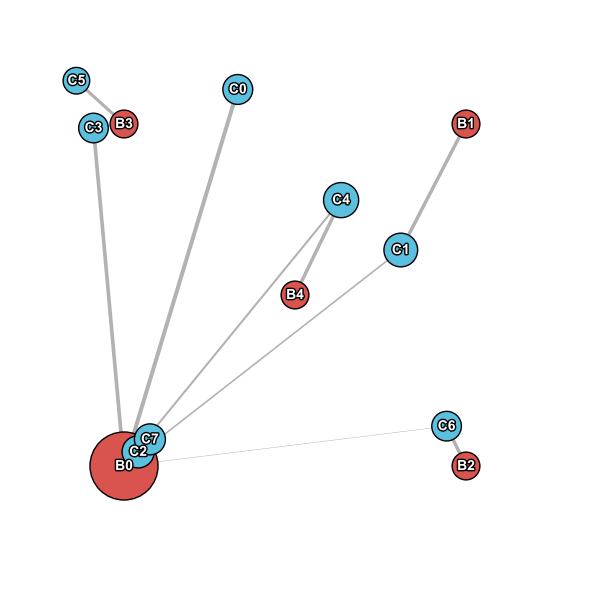

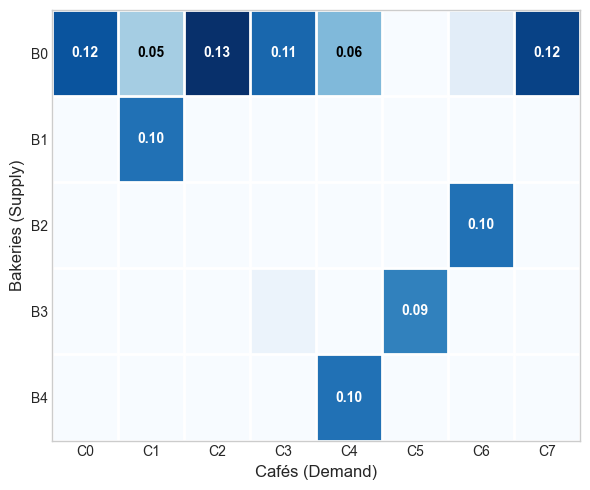

Neighbors Free (Step)     | 2.1323


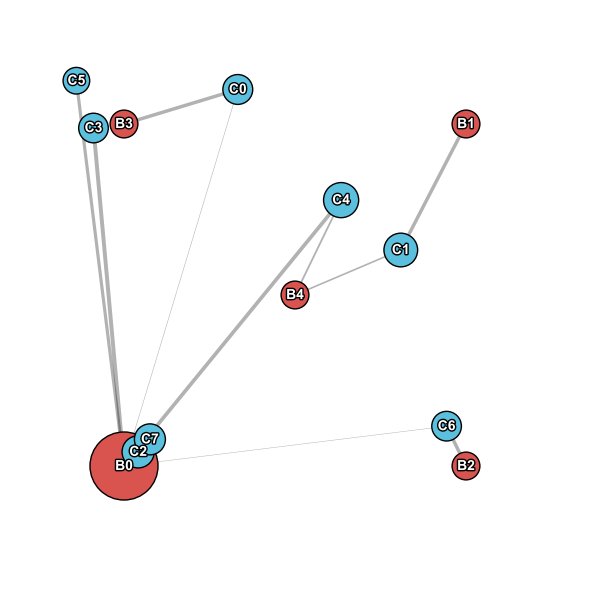

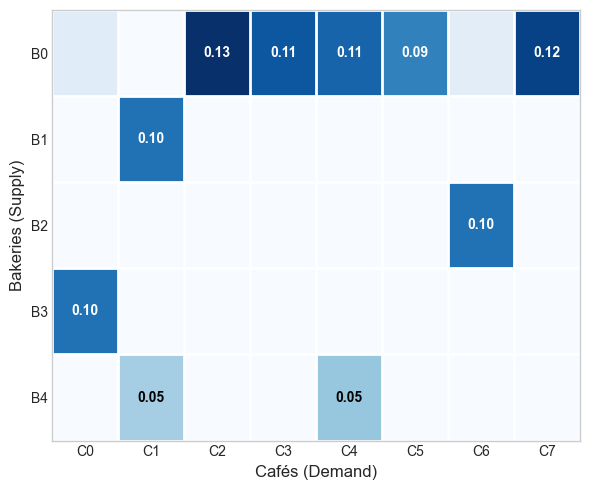

The Hill (Anisotropic)    | 6.8214


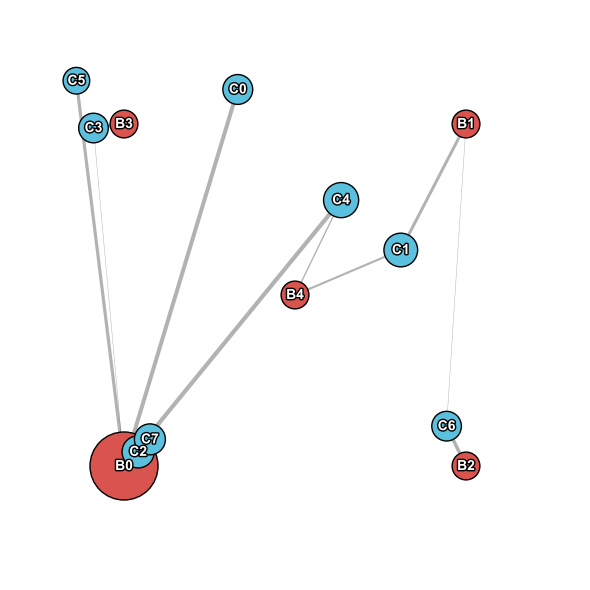

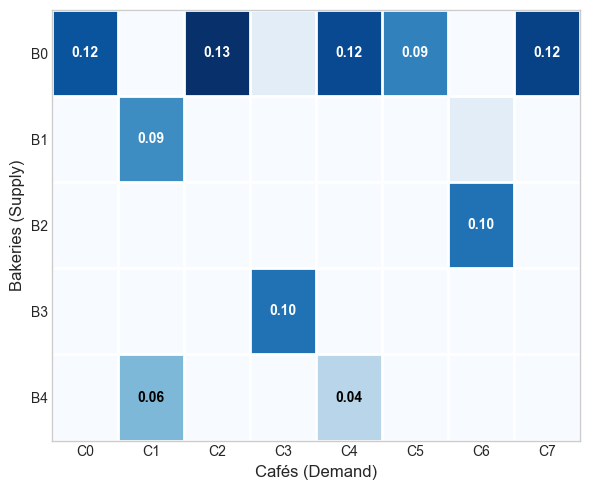


Saved 6 images to the file system.


In [6]:
# "Croissant transport" problem

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patheffects as PathEffects
import ot

# --- 1. Setup Data ---
np.random.seed(42)
n_bakeries = 5
bakery_locs = np.array([[2, 2], [8, 8], [8, 2], [2, 8], [5, 5]])
bakery_supply = np.array([0.6, 0.1, 0.1, 0.1, 0.1]); bakery_supply /= bakery_supply.sum()

n_cafes = 8
cafe_locs = np.random.rand(n_cafes, 2) * 8 + 1 
cafe_demand = np.random.rand(n_cafes) + 0.5; cafe_demand /= cafe_demand.sum()

# --- 2. Metric Logic ---
def get_solution(metric_type):
    dx = bakery_locs[:, 0][:, None] - cafe_locs[:, 0][None, :]
    dy = bakery_locs[:, 1][:, None] - cafe_locs[:, 1][None, :]
    dist = np.sqrt(dx**2 + dy**2)
    
    if metric_type == 'euclidean':
        M = dist
        name = "Baseline (Euclidean)"
        filename = "euclidean"
    elif metric_type == 'step':
        M = np.copy(dist)
        M[M < 3.0] = 0.001 
        name = "Neighbors Free (Step)"
        filename = "step"
    elif metric_type == 'hill':
        M = np.sqrt(25 * dx**2 + dy**2)
        name = "The Hill (Anisotropic)"
        filename = "hill"
        
    T = ot.emd(bakery_supply, cafe_demand, M)
    cost = np.sum(T * M)

    return M, T, name, filename, cost

# 3. Loop and Save
metrics = ['euclidean', 'step', 'hill']

print(f"{'METRIC':<25} | {'COST':<10}")
print("-" * 40)

for metric in metrics:
    M, T, name, fname, cost = get_solution(metric)
    print(f"{name:<25} | {cost:.4f}")

    # MAPS
    fig_map, ax_map = plt.subplots(figsize=(6, 6))
    
    # Draw Lines
    lines = []
    linewidths = []
    for i in range(n_bakeries):
        for j in range(n_cafes):
            if T[i, j] > 0.005: 
                lines.append([bakery_locs[i], cafe_locs[j]])
                linewidths.append(T[i, j] * 25) 
    
    lc = LineCollection(lines, colors='black', alpha=0.3, linewidths=linewidths, zorder=1)
    ax_map.add_collection(lc)
    
    # Draw Nodes
    ax_map.scatter(bakery_locs[:, 0], bakery_locs[:, 1], s=bakery_supply*4000, c='#D9534F', edgecolors='k', zorder=2)
    ax_map.scatter(cafe_locs[:, 0], cafe_locs[:, 1], s=cafe_demand*4000, c='#5BC0DE', edgecolors='k', zorder=2)
    
    # Labels (Bakeries)
    for i, (x, y) in enumerate(bakery_locs):
        txt = ax_map.text(x, y, f"B{i}", ha='center', va='center', color='white', fontweight='bold', fontsize=10, zorder=3)
        txt.set_path_effects([PathEffects.Stroke(linewidth=2, foreground='black'), PathEffects.Normal()])

    # Labels (Cafés)
    for j, (x, y) in enumerate(cafe_locs):
        txt = ax_map.text(x, y, f"C{j}", ha='center', va='center', color='white', fontweight='bold', fontsize=10, zorder=3)
        txt.set_path_effects([PathEffects.Stroke(linewidth=2, foreground='black'), PathEffects.Normal()])
    
    ax_map.set_xlim(0, 10); ax_map.set_ylim(0, 10)
    ax_map.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"map_{fname}.png", dpi=150)
    plt.show() 
    
    # MATRICES
    fig_mat, ax_mat = plt.subplots(figsize=(6, 5))
    
    # Show image
    im = ax_mat.imshow(T, cmap='Blues', aspect='auto', vmin=0)
    
    # Annotate Values
    for i in range(n_bakeries):
        for j in range(n_cafes):
            val = T[i, j]
            if val > 0.02: 
                color = "white" if val > T.max()*0.5 else "black"
                ax_mat.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=10, fontweight='bold')
        
    # GRID ALIGNMENT
    # 1. Major ticks (Labels) at integers (0, 1, 2...)
    ax_mat.set_xticks(np.arange(n_cafes))
    ax_mat.set_yticks(np.arange(n_bakeries))
    
    # 2. Minor ticks (Grid Lines) at half-integers (-0.5, 0.5, 1.5...)
    #    This puts the lines exactly BETWEEN the pixels
    ax_mat.set_xticks(np.arange(n_cafes+1)-0.5, minor=True)
    ax_mat.set_yticks(np.arange(n_bakeries+1)-0.5, minor=True)
    
    # 3. Configure the grid
    ax_mat.grid(False) # Turn off major grid (which cuts through center)
    ax_mat.grid(which="minor", color="white", linestyle='-', linewidth=2) # Turn on white minor grid
    ax_mat.tick_params(which="minor", bottom=False, left=False) # Hide the minor tick marks
    
    # Labels
    ax_mat.set_xlabel("Cafés (Demand)", fontsize=12)
    ax_mat.set_xticklabels([f"C{j}" for j in range(n_cafes)], fontsize=10)
    
    ax_mat.set_ylabel("Bakeries (Supply)", fontsize=12)
    ax_mat.set_yticklabels([f"B{i}" for i in range(n_bakeries)], fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f"matrix_{fname}.png", dpi=150)
    plt.show() 

print("\nSaved 6 images to the file system.")